In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from environment import training_columns_regex
import interpret
import matplotlib.pyplot as plt
import seaborn as sns
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import ShapKernel, LimeTabular, MorrisSensitivity, PartialDependence
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from sklearn.ensemble import RandomForestClassifier


In [6]:
!pip install xgboost

     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     --------------------------------------- 0.1/70.9 MB 262.6 kB/s eta 0:04:30
     --------------------------------------- 0.1/70.9 MB 262.6 kB/s eta 0:04:30
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44
     --------------------------------------- 0.1/70.9 MB 249.8 kB/s eta 0:04:44



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     --------------------------- ---------- 51.7/70.9 MB 990.5 kB/s eta 0:00:20
     --------------------------- ---------- 51.7/70.9 MB 987.5 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 984.5 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 981.6 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 981.6 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 969.9 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 969.9 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 969.9 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 961.4 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 957.1 kB/s eta 0:00:20
     --------------------------- ---------- 51.8/70.9 MB 954.4 kB/s eta 0:00:21
     --------------------------- ---------- 51.8/70.9 MB 954.4 kB/s eta 0:00:21
     --------------------------- -------

In [7]:
import shap

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (train_test_split)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from typing import Dict, List

from tqdm import tqdm
from pandas import DataFrame, read_pickle, read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import (train_test_split)
from sklearn.svm import SVC
from tqdm import tqdm
from environment import channels_good, Chs
from pandas import DataFrame, read_pickle
#from train_models import split_generator
from helper_functions import (glimpse_df,isnull_any, rows_with_null)


def caculate_mode_all(model: ExplainableBoostingClassifier, X_train_org: DataFrame, X_test_org: DataFrame, y_train_org: DataFrame, y_test_org: DataFrame, channels_good: list) -> List:
    """ Calculate accuracy for each channel (Acc_i) by training on the whole dataset """

    channel_acc: Dict[str, float] = {}

    for ch in tqdm(channels_good):
        X_train = X_train_org.loc[:, X_train_org.columns.str.contains(ch)]
        X_test = X_test_org.loc[:, X_test_org.columns.str.contains(ch)]
        #y_train = y_train_org["is_fatigued"]
        y_train = y_train_org.values
        #y_test = y_test_org["is_fatigued"]
        y_test = y_test_org.values
        #model = ExplainableBoostingClassifier()
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        channel_acc[ch] = accuracy_score(y_test, y_test_pred)

    """ Calculate weight for the whole dataset for each channel (V_i). """

    channel_weights = {}
    for channel_a_name in tqdm(channels_good):
        sum_elements = []
        for channel_b_name in channels_good:
            """ Calculate Acc(i,j) and add it to sum expression """
            if channel_b_name == channel_a_name:
                break

            X_train = X_train_org.loc[:, X_train_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

            X_test = X_test_org.loc[:, X_test_org.columns.str.contains("|".join([channel_a_name, channel_b_name]))]

            # y_train = y_train_org["is_adhd"]
            y_train = y_train_org.values
            # y_test = y_test_org["is_adhd"]
            y_test = y_test_org.values

            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

            acc_ij = accuracy_score(y_test, y_test_pred)
            print(acc_ij)
            sum_elements.append(acc_ij + channel_acc[channel_a_name] - channel_acc[channel_b_name])

        sum_expression = sum(sum_elements)
        acc_i = channel_acc[channel_a_name]
        weight = (acc_i + sum_expression) / len(channels_good)
        channel_weights[channel_a_name] = acc_i

    return sorted(channel_weights.items(), key=lambda x: x[1], reverse=True)

df_path = r"C:\Users\Ahmed Guebsi\Desktop\Data_test\final_modified_df.pkl"
df: DataFrame = read_pickle(df_path)
print("shaaaaaaaaaaaape",df.shape)
glimpse_df(df)
print(isnull_any(df))
# glimpse_df(df)
print(rows_with_null(df))
print("null columns df", df.columns[df.isnull().any()].tolist())
channels_good = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4',
                     'P8', '01', '02']
feature_names = ['mean', 'std', 'MIN', 'MAX', 'MED', 'PEAK', 'SKEW', 'KURT', 'R1', 'RMS', 'M1','IQR', 'Q1', 'Q2', 'Q3', 'WL', 'IEEG',
                     'SPF', 'MOM2','PE', 'MOM3', 'MAV', 'MAV1', 'MAV2', 'COV', 'CF', 'AAC', 'HURST', 'HjC', 'HA', 'HM', 'HFD',
                        'FE','RE','TE','PEN','KEN','SHAN','SUE','CE']
seed = 42
np.random.seed(seed)
# Find columns with null values    
columns_with_null = df.columns[df.isnull().any()]
print(len(columns_with_null))

    # Access columns with "Fp1" in their name
columns_with_f1 = [col for col in df.columns if 'Fp1' in col]

    # Access the data of selected columns
data_with_f1 = df[columns_with_f1]

    # Print the data of selected columns
print(data_with_f1.head(60))

    # Remove rows with null values
    # df_cleaned = df.dropna().reset_index(drop=True)
df_cleaned = df.dropna(axis=1)

print(df_cleaned.shape)
columns_to_drop = df_cleaned.columns[df_cleaned.columns.str.contains('LEN|PFD|KFD|LE|SE|psd|delta|theta|alpha|beta|alpha_ratio|theta_ratio|beta_ratio|delta_ratio|theta_bata_ratio')]
df_test = df_cleaned.drop(columns=columns_to_drop)
print(df_test.shape)
    # Load data and labels
X = df_test.drop(["is_adhd","epoch_id","child_id"], axis=1)
y = df_test.loc[:, "is_adhd"]
    # Split data into training and testing sets
    #X_train, X_test, y_train, y_test = split_generator(X, y)
    
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=seed)

    # train an XGBoost model
    #X, y = shap.datasets.boston()
    #model = xgboost.XGBRegressor().fit(X, y)
model = GradientBoostingClassifier().fit(X, y)

    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
    
explainer = shap.Explainer(model)
shap_values = explainer(X)

    # visualize the first prediction's explanation
    
res = shap.plots.waterfall(shap_values[0])

shaaaaaaaaaaaape (4133, 991)

Showing first 3 data points



,is_adhd,child_id,epoch_id,Fp2_mean_standard,Fp2_std_standard,Fp2_MIN_standard,Fp2_MAX_standard,Fp2_PEAK_standard,Fp2_MED_standard,Fp2_Q2_standard,...,Fp1_SUE_standard,Fp1_delta_standard,Fp1_theta_standard,Fp1_alpha_standard,Fp1_beta_standard,Fp1_alpha_ratio_standard,Fp1_beta_ratio_standard,Fp1_delta_ratio_standard,Fp1_theta_ratio_standard,Fp1_theta_beta_ratio_standard
0,0,0,0,21.002604,29.618888,0.138869,130.863209,130.863209,7.879190,7.879190,...,4370.726242,25482.241124,6204.687806,2981.319187,2965.829767,0.079219,0.078807,0.677106,0.164869,2.092058
1,0,0,1,29.628192,33.428434,0.906824,216.287455,216.287455,19.187032,19.187032,...,4565.110031,37234.324391,10102.438855,3136.423066,4262.917203,0.057301,0.077881,0.680252,0.184566,2.369842
2,0,0,2,19.152944,11.991159,0.287843,61.247266,61.247266,15.710143,15.710143,...,4578.547114,11944.199965,4447.720427,1541.707621,977.604692,0.081523,0.051694,0.631593,0.235189,4.549610



Showing last 3 data points



,is_adhd,child_id,epoch_id,Fp2_mean_standard,Fp2_std_standard,Fp2_MIN_standard,Fp2_MAX_standard,Fp2_PEAK_standard,Fp2_MED_standard,Fp2_Q2_standard,...,Fp1_SUE_standard,Fp1_delta_standard,Fp1_theta_standard,Fp1_alpha_standard,Fp1_beta_standard,Fp1_alpha_ratio_standard,Fp1_beta_ratio_standard,Fp1_delta_ratio_standard,Fp1_theta_ratio_standard,Fp1_theta_beta_ratio_standard
4130,1,59,19,20.439018,9.970070,1.610584,46.762183,46.762183,18.357354,18.357354,...,4585.329333,10623.108355,3091.062217,994.490281,1225.555299,0.062412,0.076913,0.666685,0.193989,2.522173
4131,1,59,20,34.758395,18.805294,0.263614,83.314003,83.314003,32.873299,32.873299,...,4552.072378,17091.286751,6501.207772,1446.931659,1736.744055,0.054038,0.064862,0.638302,0.242798,3.743331
4132,1,59,21,37.673126,20.631794,3.468260,89.486795,89.486795,35.375254,35.375254,...,4608.000000,17931.016823,5863.084681,1509.498788,1229.428174,0.056891,0.046336,0.675800,0.220973,4.768953



Showing 3 radnom data points



,is_adhd,child_id,epoch_id,Fp2_mean_standard,Fp2_std_standard,Fp2_MIN_standard,Fp2_MAX_standard,Fp2_PEAK_standard,Fp2_MED_standard,Fp2_Q2_standard,...,Fp1_SUE_standard,Fp1_delta_standard,Fp1_theta_standard,Fp1_alpha_standard,Fp1_beta_standard,Fp1_alpha_ratio_standard,Fp1_beta_ratio_standard,Fp1_delta_ratio_standard,Fp1_theta_ratio_standard,Fp1_theta_beta_ratio_standard
1864,0,27,25,19.944246,8.184732,0.964225,34.327384,34.327384,19.226254,19.226254,...,4581.309396,8907.670643,2573.753751,1447.149470,2296.167944,0.095052,0.150818,0.585079,0.169051,1.120891
1210,1,17,22,16.431249,8.742479,0.797985,49.648216,49.648216,15.344003,15.344003,...,4590.638519,9735.427784,3566.803332,1416.753172,1784.725511,0.085845,0.108141,0.589893,0.216121,1.998516
1924,0,28,20,4.319608,2.075834,0.346614,9.851854,9.851854,4.279218,4.279218,...,4161.607042,2113.616037,1072.189729,399.812003,727.732370,0.092692,0.168716,0.490017,0.248575,1.473330


,is_adhd,child_id,epoch_id,Fp2_mean_standard,Fp2_std_standard,Fp2_MIN_standard,Fp2_MAX_standard,Fp2_PEAK_standard,Fp2_MED_standard,Fp2_Q2_standard,...,Fp1_SUE_standard,Fp1_delta_standard,Fp1_theta_standard,Fp1_alpha_standard,Fp1_beta_standard,Fp1_alpha_ratio_standard,Fp1_beta_ratio_standard,Fp1_delta_ratio_standard,Fp1_theta_ratio_standard,Fp1_theta_beta_ratio_standard
count,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,...,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000
mean,0.554077,30.026131,18.852649,22.611109,13.781554,1.157827,68.689922,68.689922,20.148274,20.148274,...,4536.882433,13928.850149,4886.202502,1740.461071,2212.983254,0.080645,0.106751,0.592425,0.220178,2.315205
std,0.497127,17.417731,13.869685,11.504826,10.637450,1.101769,58.840478,58.840478,10.109798,10.109798,...,138.854112,10606.469679,3117.356628,1073.004632,1476.906561,0.019936,0.038921,0.073630,0.043783,0.874790
min,0.000000,0.000000,0.000000,3.135401,1.569301,0.008611,7.181616,7.181616,2.786860,2.786860,...,3600.359960,1226.712498,481.599209,151.885015,398.152714,0.016043,0.020072,0.319409,0.063911,0.417903
25%,0.000000,15.000000,8.000000,15.865791,8.869851,0.412480,42.591899,42.591899,13.931969,13.931969,...,4557.680203,8937.832632,3447.038282,1196.992969,1451.217062,0.067683,0.079093,0.543753,0.191759,1.654336
50%,1.000000,30.000000,17.000000,21.660513,12.012406,0.843422,58.148961,58.148961,19.733955,19.733955,...,4588.356226,12208.935713,4624.981034,1615.762727,1916.516612,0.079413,0.098850,0.592674,0.221268,2.244136
75%,1.000000,46.000000,27.000000,28.031328,16.265461,1.508170,80.165042,80.165042,25.524943,25.524943,...,4601.558257,16639.560234,6036.817801,2099.530160,2567.211559,0.092803,0.127482,0.638542,0.249338,2.858637
max,1.000000,59.000000,83.000000,97.236171,244.544104,10.889828,1530.711000,1530.711000,72.371708,72.371708,...,4627.722450,247257.142828,101705.095505,25988.140020,31946.658408,0.176055,0.290704,0.891635,0.356720,7.914961


is_adhd                          False
child_id                         False
epoch_id                         False
Fp2_mean_standard                False
Fp2_std_standard                 False
                                 ...  
Fp1_alpha_ratio_standard         False
Fp1_beta_ratio_standard          False
Fp1_delta_ratio_standard         False
Fp1_theta_ratio_standard         False
Fp1_theta_beta_ratio_standard    False
Length: 991, dtype: bool
Empty DataFrame
Columns: [is_adhd, child_id, epoch_id, Fp2_mean_standard, Fp2_std_standard, Fp2_MIN_standard, Fp2_MAX_standard, Fp2_PEAK_standard, Fp2_MED_standard, Fp2_Q2_standard, Fp2_Q1_standard, Fp2_Q3_standard, Fp2_IQR_standard, Fp2_KURT_standard, Fp2_SKEW_standard, Fp2_SE_standard, Fp2_PE_standard, Fp2_psd_standard, Fp2_MOM2_standard, Fp2_MOM3_standard, Fp2_MAV_standard, Fp2_RMS_standard, Fp2_MAV1_standard, Fp2_MAV2_standard, Fp2_WL_standard, Fp2_AAC_standard, Fp2_M1_standard, Fp2_COV_standard, Fp2_R1_standard, Fp2_CF_standard, Fp2_IE

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

NameError: name 'explainer' is not defined

In [2]:
!pip3 install interpret 

  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.0.1
    Uninstalling Werkzeug-2.0.1:
      Successfully uninstalled Werkzeug-2.0.1



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
conda install -c conda-forge interpret


Note: you may need to restart the kernel to use updated packages.Retrieving notices: ...working... done
Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\anaconda3

  added / updated specs:
    - interpret


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.7.2               |  py311h1ea47a8_0         1.3 MB  conda-forge
    notebook-6.5.2             |     pyha770c72_0         270 KB  conda-forge
    openssl-1.1.1v             |       hcfcfb64_0         5.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.6 MB

The following packages will be UPDATED:

  ca-certificates                    

In [126]:
!pip install werkzeug==2.0.1


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
df_path=r"C:\Users\Ahmed Guebsi\Desktop\Data_test\final_hilbert_dataframe.pkl"
df: DataFrame = read_pickle(df_path)
        
df_path=r"C:\Users\Ahmed Guebsi\Desktop\Data_test\SHAN_dataframe.pkl"
df_shan: DataFrame = read_pickle(df_path)
    
df_path=r"C:\Users\Ahmed Guebsi\Desktop\Data_test\RE_dataframe.pkl"
df_re: DataFrame = read_pickle(df_path)
    
df_path=r"C:\Users\Ahmed Guebsi\Desktop\Data_test\TE_dataframe.pkl"
df_te: DataFrame = read_pickle(df_path)
    
df_path=r"C:\Users\Ahmed Guebsi\Desktop\Data_test\KE_dataframe.pkl"
df_ke: DataFrame = read_pickle(df_path)
# Convert complex values to real df_real = df.applymap(lambda x: x.real)
print(df.shape)
seed = 42
np.random.seed(seed)
# Find columns with null values
columns_with_null = df.columns[df.isnull().any()]

print(len(columns_with_null))

# Access columns with "Fp1" in their names
columns_with_f1 = [col for col in df.columns if 'Fp1' in col]

# Access the data of selected columns
data_with_f1 = df[columns_with_f1]

# Print the data of selected columns
#print(data_with_f1.head(60))

# Remove rows with null values
#df_cleaned = df.dropna().reset_index(drop=True)
df_cleaned = df.dropna(axis=1)

print(df_cleaned.shape)

columns_to_drop = df_cleaned.columns[df_cleaned.columns.str.contains('LEN|PFD|KFD|LE|SE|psd|KEN|alpha|beta|theta|delta|alpha_ratio|theta_ratio|beta_ratio|delta_ratio|theta_beta_ratio')]
df_test = df_cleaned.drop(columns=columns_to_drop,axis=1)
print(df_test.head(10))
#df_new_test = df_test.copy()
df_new_test =pd.concat([df_test, df_ke], axis=1)
print(df_new_test.shape)

print(df_new_test.shape)
print(df_new_test.head(10))
X = df_test.drop(["is_adhd", "epoch_id", "child_id"], axis=1)
y = df_test.loc[:, "is_adhd"]
print(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))


(4133, 991)
39
(4133, 952)
   is_adhd  child_id  epoch_id  Fp1_mean_standard  Fp1_std_standard  \
0        0         0         0                0.0               0.0   
1        0         0         1                1.0               0.0   
2        0         0         2                2.0               0.0   
3        0         0         3                3.0               0.0   
4        0         0         4                4.0               0.0   
5        0         0         5                5.0               0.0   
6        0         0         6                6.0               0.0   
7        0         0         7                7.0               0.0   
8        0         0         8                8.0               0.0   
9        0         0         9                9.0               0.0   

   Fp1_MIN_standard  Fp1_MAX_standard  Fp1_PEAK_standard  Fp1_MED_standard  \
0               0.0               0.0                0.0               0.0   
1               1.0               1

In [ ]:
print(X['Fp1_std_standard'])

In [8]:
print(ebm.score(X_test, y_test, sample_weight=None))

0.7762998790810157


In [107]:
print(columns_with_null)
columns_dropped = df.columns[df.columns.str.contains('PEN')]
print(len(columns_dropped))
print(df.iloc[:,:3].head())

Index([], dtype='object')
19
   is_adhd  child_id  epoch_id
0        0         0         0
1        0         0         1
2        0         0         2
3        0         0         3
4        0         0         4


In [103]:
print(columns_dropped)

Index(['Fp1_mean_standard', 'Fp1_std_standard', 'Fp1_MIN_standard',
       'Fp1_MAX_standard', 'Fp1_MED_standard', 'Fp1_Q2_standard',
       'Fp1_Q1_standard', 'Fp1_Q3_standard', 'Fp1_IQR_standard',
       'Fp1_KURT_standard', 'Fp1_SKEW_standard', 'Fp1_MOM2_standard',
       'Fp1_MOM3_standard', 'Fp1_MAV_standard', 'Fp1_RMS_standard',
       'Fp1_MAV1_standard', 'Fp1_MAV2_standard', 'Fp1_WL_standard',
       'Fp1_AAC_standard', 'Fp1_M1_standard', 'Fp1_COV_standard',
       'Fp1_R1_standard', 'Fp1_CF_standard', 'Fp1_IEEG_standard',
       'Fp1_SPF_standard', 'Fp1_HFD_standard', 'Fp1_HM_standard',
       'Fp1_HjC_standard', 'Fp1_HA_standard', 'Fp1_HURST_standard',
       'Fp1_KEN_standard', 'Fp1_CE_standard', 'Fp1_FE_standard',
       'Fp1_SHAN_standard', 'Fp1_RE_standard', 'Fp1_TE_standard',
       'Fp1_SUE_standard'],
      dtype='object')


In [36]:
print(ebm.predict_and_contrib(X_test, output='probabilities', init_score=None))

(array([[0.93861292, 0.06138708],
       [0.31202585, 0.68797415],
       [0.84098588, 0.15901412],
       ...,
       [0.54804366, 0.45195634],
       [0.23869772, 0.76130228],
       [0.0197662 , 0.9802338 ]]), array([[-0.01768685,  0.        , -0.01712989, ...,  0.00927585,
         0.01787334, -0.01487549],
       [-0.018142  ,  0.        , -0.01775742, ..., -0.03611035,
         0.02346668,  0.022395  ],
       [-0.018142  ,  0.        , -0.01775742, ...,  0.07284355,
        -0.01162609,  0.21127689],
       ...,
       [-0.018142  ,  0.        , -0.01775742, ..., -0.04395924,
         0.02299388,  0.02613678],
       [-0.018142  ,  0.        , -0.01775742, ..., -0.01391178,
        -0.01263078, -0.02618039],
       [ 0.11953785,  0.        ,  0.12697761, ..., -0.03859992,
         0.03253646,  0.022395  ]]))


In [37]:
print(ebm.predict(X_test, init_score=None))

[0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0
 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0
 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0
 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0
 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1
 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0
 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1
 1 1 1 1 1 0 0 1 1 0 0 1 

In [38]:
print(ebm.decision_function(X, init_score=None))

[-1.241937   -0.24627269 -3.03440018 ...  1.18134915  1.84167367
 -0.67298887]


In [39]:
print(ebm.term_importances(importance_type='avg_weight'))

[2.87116123e-02 0.00000000e+00 2.79208852e-02 2.66220533e-02
 2.65270993e-02 2.59506454e-02 2.63812574e-02 2.57273092e-02
 0.00000000e+00 2.59051436e-02 2.51302012e-02 2.59392819e-02
 2.48403509e-02 0.00000000e+00 2.16840434e-19 0.00000000e+00
 2.55051984e-02 2.48887631e-02 2.50162007e-02 0.00000000e+00
 2.16840434e-19 0.00000000e+00 4.11259842e-03 6.20945435e-03
 6.23295579e-03 1.43570386e-02 7.45200473e-03 6.67760277e-03
 6.37335308e-03 6.61162129e-03 6.14667731e-03 4.64975846e-03
 4.85316189e-03 4.78996142e-03 7.03856522e-03 4.73589641e-03
 1.05030577e-02 6.62762575e-03 1.05536349e-02 6.38616770e-03
 3.40496436e-03 1.18301773e-02 4.80238638e-03 4.76354292e-03
 6.06353152e-03 5.68809902e-03 5.95374122e-03 4.55715829e-03
 7.77753018e-03 5.94418388e-03 1.67820553e-02 4.72790099e-03
 1.01430003e-02 1.70717763e-02 6.90602002e-03 7.13293932e-03
 6.18841083e-03 5.32256990e-03 5.25834868e-03 1.10573532e-02
 1.63909460e-02 1.46725412e-02 8.68816247e-03 1.39840342e-02
 1.60481831e-02 1.594488

Explained Variance Ratio: [0.17384634 0.07694788 0.04352542 0.03193029 0.02971291 0.02719328
 0.02269911 0.02148039 0.01991341 0.01916189 0.01819593 0.01772566
 0.01700432 0.01675677 0.01586641 0.01524395 0.0146631  0.01442778
 0.01368203 0.01330721]


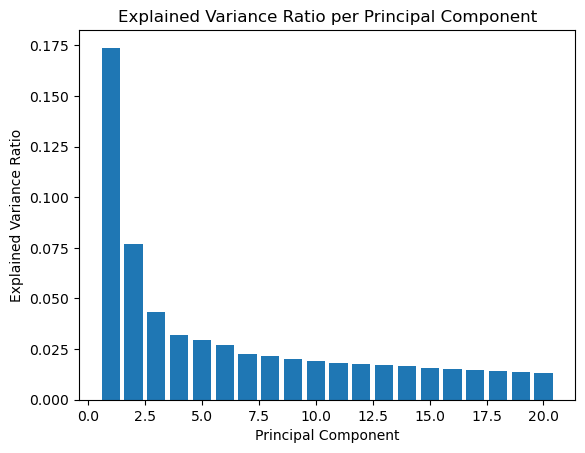

            PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0      2.311847  23.280194 -1.241353 -4.407306 -4.666423  1.900331  0.361202   
1      0.905716   4.425399 -2.510533 -1.277471 -3.815025  5.297037 -2.922345   
2     -9.500868   2.596493  0.934652 -2.169778  2.330529  1.149120 -1.054863   
3     -5.567549   2.909090 -0.610582 -0.919681 -1.840290  3.602168 -0.134954   
4      0.101648  -0.499533 -1.209814 -2.063043 -2.906418  3.539721 -0.071024   
...         ...        ...       ...       ...       ...       ...       ...   
4128  -6.765610   1.114765 -4.713914  0.887148  3.225716 -3.995479 -0.479943   
4129  -7.008941  -0.348419  2.463573 -4.987726  8.543554  1.680967 -6.616928   
4130  -6.193964  -0.876242 -2.353765 -1.143296  3.569343 -2.909757 -0.925717   
4131 -10.270175   2.396483  3.814092 -3.692630  6.107483  1.680514 -4.268279   
4132  -6.631384   2.528688  3.898919 -6.018996  5.435576 -4.690589 -2.457650   

           PC8       PC9      PC10     

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_test)

# Initialize PCA with the number of components you want to keep
num_components = 20
pca = PCA(n_components=num_components)

# Fit and transform the scaled data using PCA
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Visualize the explained variance ratio
plt.bar(range(1, num_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')
plt.show()

print(principal_df)

In [10]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# See Sklearn documentation

import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.028 seconds


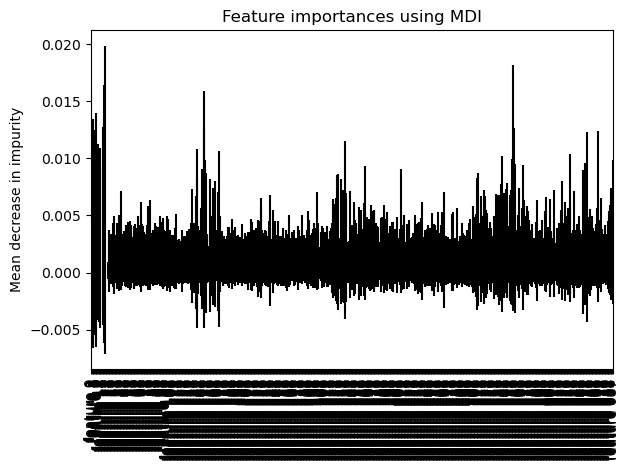

In [12]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [13]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 169.790 seconds


688
[0.004550154225447825, 0.004300705983985194, 0.004075525887872503, 0.003669647135548611, 0.003496210954002647, 0.003471027834197645, 0.0033422672215442048, 0.0033247223905362704, 0.0033092943611617736, 0.003298230156465754, 0.003208343207115254, 0.003162441797006543, 0.00315549899654169, 0.003143893591293856, 0.003127573677479458, 0.0030970371160497483, 0.003049460752821889, 0.0030132855609134347, 0.002971754710385597, 0.002964365337879385, 0.0029520086132366866, 0.0029346217894828572, 0.002922139292284061, 0.0029020556227327653, 0.002874211444741164, 0.0028742114447411525, 0.0028716667683283963, 0.002871666768328384, 0.0028640191734769075, 0.002864019173476884, 0.0028099032741528886, 0.0027706019921135473, 0.002728056631844845, 0.0027065331663360653, 0.0027038306862149667, 0.002692993645866994, 0.002649202212842404, 0.002649202212842384, 0.002638140777420956, 0.0026186708376913833, 0.002618670837691361, 0.002607479885471322, 0.002596240695717548, 0.0025821229146387663, 0.002582122

ValueError: 'yerr' (shape: (10,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (688,))

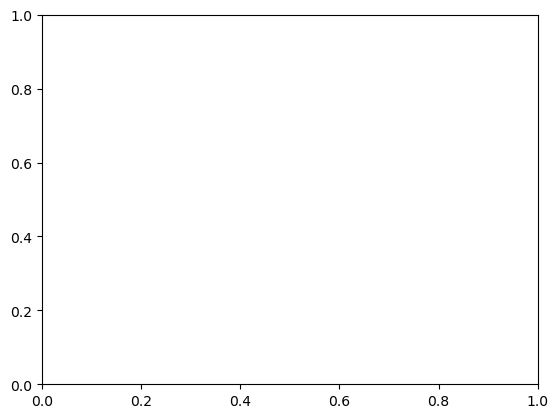

In [20]:
print(len(feature_names))
print(sorted(result.importances_std, reverse=True))

best_result=sorted(result.importances_std, reverse=True)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=best_result[:10], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Initialize PCA with the number of components you want to keep
num_components = len(df.columns)  # Use all components initially
pca = PCA(n_components=num_components)

# Fit and transform the scaled data using PCA
principal_components = pca.fit_transform(df_scaled)

# Calculate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: Explained Variance Ratio = {ratio:.4f}")

# Identify the most important components based on explained variance
most_important_components = pca.components_[:17]  # Choose the top 17 components
print("\nMost Important Components (PC1 and PC2):\n", most_important_components)


In [ ]:
cor = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()  

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr     

corr_features = correlation(X_train, 0.7)
Corr_features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)

In [ ]:
from sklearn.feature_selection import chi2 #Calculating Fscore and p value
#the more the value of the F score the more important the feature is and the lesser the value of the p-value
#the more important will be the feature
f_p_values=chi2(X_train,y_train)
F_p_values

In [ ]:
import pandas as pd 
p_values=pd.Series(f_p_values[1]) #turning it into list
p_values.index=X_train.columns
P_values  

In [ ]:
from sklearn.feature_selection import mutual_info_classif #feature selection using mutual information
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8)

In [ ]:
from sklearn.feature_selection import SelectKBest
#No we Will select the top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

In [21]:
!pip install dash


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
show(ebm.explain_global())

ImportError: cannot import name 'get_current_traceback' from 'werkzeug.debug.tbtools' (C:\ProgramData\anaconda3\Lib\site-packages\werkzeug\debug\tbtools.py)

In [8]:
show(ebm.explain_local(X_test[:5], y_test[:5]), 0)

ImportError: cannot import name 'get_current_traceback' from 'werkzeug.debug.tbtools' (C:\ProgramData\anaconda3\Lib\site-packages\werkzeug\debug\tbtools.py)

In [41]:
pca = PCA()
rf = RandomForestClassifier(random_state=seed)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)

lime = LimeTabular(blackbox_model, X_train)
show(lime.explain_local(X_test[:5], y_test[:5]), 0)

plt.show()

pdp = PartialDependence(blackbox_model, X_train)
show(pdp.explain_global(), 0)

msa = MorrisSensitivity(blackbox_model, X_train)
show(msa.explain_global())

shap = ShapKernel(blackbox_model, X_train)
shap_local = shap.explain_local(X_test[:5], y_test[:5])

show(shap_local, 0)

ImportError: cannot import name 'get_current_traceback' from 'werkzeug.debug.tbtools' (C:\ProgramData\anaconda3\Lib\site-packages\werkzeug\debug\tbtools.py)

In [132]:
model = RandomForestClassifier()
y_trues = []
y_preds = []
print(X_train)
model.fit(X_train, y_train)
y_true_test, y_pred_test = y_test, model.predict(X_test.values)
print(y_true_test)
print(type(y_true_test))
y_trues.append(y_true_test)
y_preds.append(y_pred_test)
accuracy = accuracy_score(y_trues, y_preds)
print(accuracy)

      Fp2_mean_standard  Fp2_std_standard  Fp2_MIN_standard  Fp2_MAX_standard  \
173           37.798012         17.812758          3.761890         86.640057   
1022          33.022747         17.437043          0.705632         71.119237   
3182          16.079143          7.793382          1.948105         38.444134   
331           17.627963         11.131256          1.536811         52.558955   
2222           4.839676          2.053003          0.120761         10.822954   
...                 ...               ...               ...               ...   
3444          17.123285         24.318342          0.541095        129.593257   
466            3.412944          2.054906          0.071238          8.737150   
3092           4.091835          1.761553          0.411356          8.128190   
3772          31.254030         16.312211          2.486458         77.042334   
860           24.230818         13.027032          1.597923         60.185695   

      Fp2_PEAK_standard  Fp

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [134]:
importances = model.feature_importances_
importances

array([0.00067258, 0.00030563, 0.00081478, 0.00085257, 0.00033274,
       0.00079627, 0.00056351, 0.00060114, 0.00062268, 0.00053959,
       0.00084395, 0.00078117, 0.00144426, 0.00064012, 0.00054947,
       0.00067748, 0.00058842, 0.00049752, 0.00046031, 0.00074427,
       0.00087066, 0.0006537 , 0.00059519, 0.00077024, 0.00092802,
       0.00101833, 0.00075182, 0.00066433, 0.00090653, 0.00068609,
       0.00059189, 0.00089074, 0.00054737, 0.00069743, 0.00079194,
       0.00081943, 0.000776  , 0.00105484, 0.0013559 , 0.        ,
       0.00066727, 0.00039452, 0.00089565, 0.00073003, 0.00077493,
       0.00076695, 0.0010751 , 0.00140805, 0.00081355, 0.00085686,
       0.00091626, 0.00051036, 0.00125336, 0.00060853, 0.00090436,
       0.00249583, 0.00112282, 0.0033348 , 0.00345984, 0.00354369,
       0.00318331, 0.00215964, 0.00077317, 0.00105469, 0.00103112,
       0.00113321, 0.00313674, 0.00174672, 0.00222352, 0.00273011,
       0.00325398, 0.00287302, 0.00265856, 0.00323837, 0.00294

In [136]:
import pandas as pd
final_df = pd.Dataframe({"Features": pd.Dataframe(X).columns, "Importances": importances})
final_df.set_index("Importances")
final_df = final_df.sort_values("Importances")

final_df.plot.bar(color ='teal')

AttributeError: module 'pandas' has no attribute 'Dataframe'